In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import re
from sklearn.model_selection import train_test_split
from pycaret.classification import *
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, StringTensorType
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from skl2onnx import to_onnx
from onnxruntime import InferenceSession
from pycaret.classification import ClassificationExperiment

In [2]:
# Read data
raw_data = pd.read_csv(r'C:\Users\cierl\OneDrive\Pulpit\pycaret_onnx\ga4_pycaret_onnx\dataset.csv')

In [13]:
# Shuffle data
data = raw_data.sample(frac = 1, random_state = 1234)

In [4]:
# Drop columns with other than numeric or categorical values
data = data.iloc[:,4:]

In [5]:
# Split Y and X
y = data.y_added_to_cart
data = data.drop(columns=['y_added_to_cart']).copy()

In [6]:
# Fill null values for categorical columns with 'No_data'
train_columns = data.columns
for col in train_columns:
      if col.startswith('c_'):
         data[col] = data[col].fillna('No_data')  

In [7]:
# Find rare values (less then 1% of cases) and replace them with 'Other'
for col in train_columns:
      if col.startswith('c_'):
         data[col] = np.where(data[col].isin(data[col].value_counts()[data[col].value_counts(normalize=True) < 0.01].index), 'Other', data[col])   


In [8]:
# One hot encoding for categorical columns
data = pd.get_dummies(data, columns = train_columns[train_columns.str.startswith('c_')].tolist())

In [9]:
# Rename columns with regex
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))

In [10]:
# Find numeric and categorical columns
train_columns = data.columns
cat = train_columns[train_columns.str.startswith('c_')].tolist()
num = train_columns[train_columns.str.startswith('n_')].tolist()

In [11]:
# Setup an experiment
setup(data,
          target = y,
          session_id = 123,
          train_size = 0.8,
          numeric_features = num,
          categorical_features = cat,
          numeric_imputation = 'mean',
          transformation = True,
          normalize = True,
          fold = 10
          )

,Description,Value
0,Session id,123
1,Target,y_added_to_cart
2,Target type,Binary
3,Original data shape,"(26374, 57)"
4,Transformed data shape,"(26374, 57)"
5,Transformed train set shape,"(21099, 57)"
6,Transformed test set shape,"(5275, 57)"
7,Ordinal features,51
8,Numeric features,5
9,Categorical features,51


In [14]:
# Compare models
models_to_compare = ['dummy', 'lr', 'knn',
                     'nb', 'dt', 'rbfsvm', 
                     'mlp', 'rf', 'ada',
                     'gbc', 'lda', 'et',
                     'xgboost', 'lightgbm', 'catboost']

In [15]:
# Find best model
best = compare_models(sort = 'AUC', include = models_to_compare)

In [16]:
results = pull()
print(results)

                                    Model  Accuracy     AUC  Recall   Prec.  \
lr                    Logistic Regression    0.9711  0.9752  0.1555  0.5929   
gbc          Gradient Boosting Classifier    0.9732  0.9735  0.2847  0.6377   
catboost              CatBoost Classifier    0.9728  0.9732  0.3439  0.5981   
lightgbm  Light Gradient Boosting Machine    0.9723  0.9731  0.3625  0.5786   
xgboost         Extreme Gradient Boosting    0.9711  0.9724  0.3392  0.5517   
ada                  Ada Boost Classifier    0.9714  0.9703  0.2441  0.5564   
lda          Linear Discriminant Analysis    0.9425  0.9667  0.7745  0.3182   
rf               Random Forest Classifier    0.9706  0.9631  0.1835  0.5605   
nb                            Naive Bayes    0.9284  0.9606  0.8369  0.2770   
mlp                        MLP Classifier    0.9641  0.9579  0.2640  0.3726   
rbfsvm                SVM - Radial Kernel    0.9694  0.9518  0.0000  0.0000   
et                 Extra Trees Classifier    0.9670 

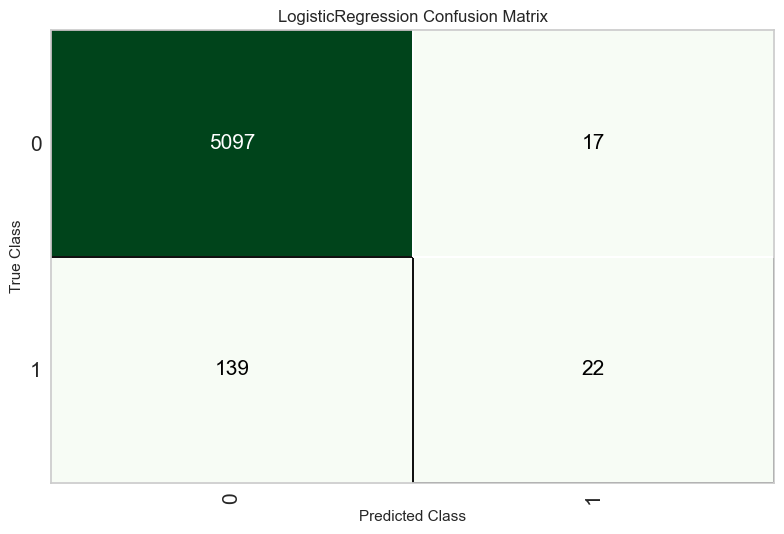

In [17]:
plot_model(best, plot = 'confusion_matrix')

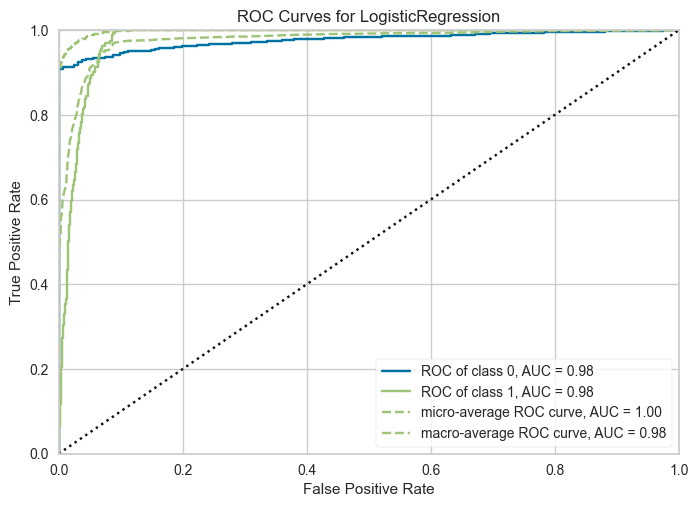

In [18]:
plot_model(best, plot = 'auc')

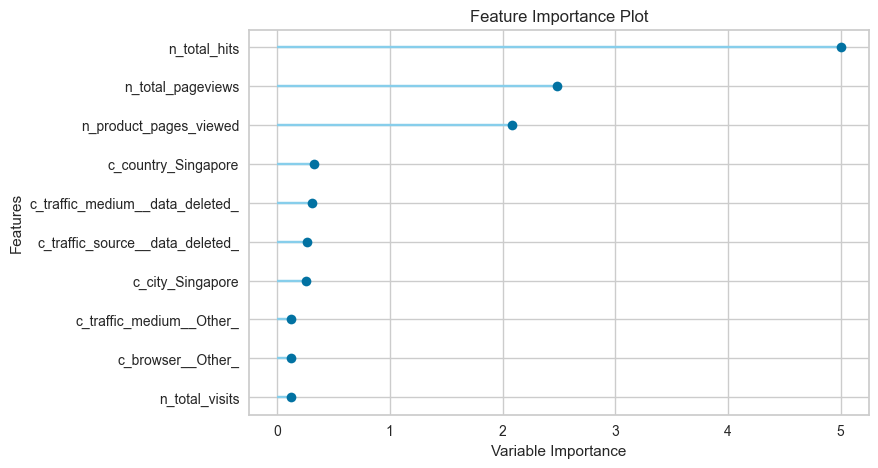

In [23]:
plot_model(best, plot = 'feature')

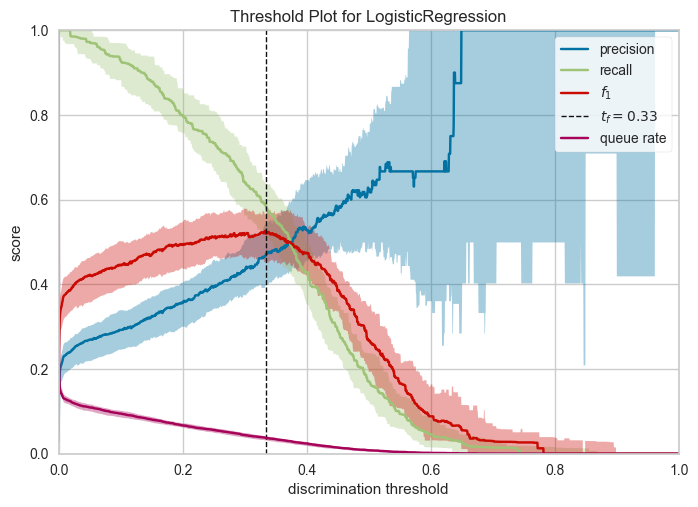

In [25]:
plot_model(best, plot = 'threshold')

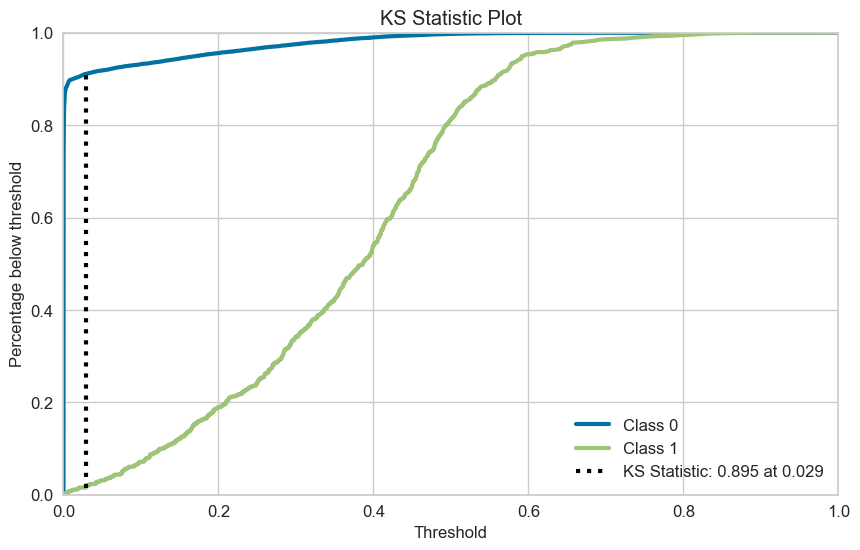

In [30]:
plot_model(best, plot = 'ks')

In [18]:
# Save model to onnx format
data_sample = get_config('X_test')[:1]
options = {id(best): {'zipmap': False}}
model_onnx = to_onnx(best, data_sample.to_numpy() , options=options)

In [19]:
# Load model from onnx format and run inference
sess = InferenceSession(model_onnx.SerializeToString())
X_test = get_config('X_test_transformed').to_numpy()
predictions_onnx = sess.run(None, {'X': X_test})

In [20]:
# Save model to a disc
with open("ga4.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())